In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns
from clust import KMeans

In [48]:
X, y = make_blobs(n_samples=1000, n_features=3, centers=4, random_state=0)

array([[-2.32100258,  5.77284654,  0.48787998],
       [-1.21998291,  7.74692279,  9.27880438],
       [ 0.86394622, -1.43385594,  2.96874457],
       [ 1.0217045 ,  4.21898859,  1.92721464]])

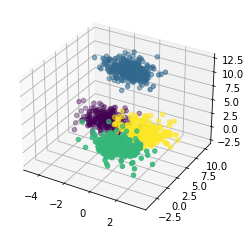

In [49]:
m = KMeans(X, n_clusters=4, n_features=3).fit(heur='sample')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=m.labels)
ax.scatter(m.centroids[:, 0], m.centroids[:, 1], m.centroids[:, 2], s=200)
m.centroids

# ax = fig.add_subplot(projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
# ax.scatter(m.centroids[:, 0], m.centroids[:, 1], m.centroids[:, 2], s=200)